In [1]:
from dask.distributed import Client, progress
client = Client(threads_per_worker=5, n_workers=1)
client

/usr/common/software/python/3.8-anaconda-2021.05/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42207 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:42613 Dashboard: http://127.0.0.1:42207/status,Cluster Workers: 1 Cores: 5 Memory: 503.05 GiB


In [2]:
print(client)

<Client: 'tcp://127.0.0.1:42613' processes=1 threads=5, memory=503.05 GiB>


In [3]:
client.cluster.scale(50)

In [4]:
client

Client Scheduler: tcp://127.0.0.1:42613 Dashboard: http://127.0.0.1:42207/status,Cluster Workers: 1 Cores: 5 Memory: 503.05 GiB


In [ ]:
pr

___

Open a Jupyter terminal tab (or regular Cori terminal), and run these commands:

    cd $SCRATCH
    module load nersc-dask
    start-dask-mpi --ntasks=256 --image=stephey/nersc-dask-example:v0.6.0

In [4]:
import os

import dask
from dask.distributed import Client

scheduler_file = os.path.join(os.environ["SCRATCH"], "scheduler.json")
dask.config.config["distributed"]["dashboard"]["link"] = "{JUPYTERHUB_SERVICE_PREFIX}proxy/{host}:{port}/status"

In [ ]:
client = Client(scheduler_file=scheduler_file)

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from scipy import interpolate
import pickle
import dask

In [3]:
#Read in raw data Interp_load and TimeRange_load.
#Interp_load is a dictionary with 6 keys (bands in our case), 
#the item of each of them is a list that contains 40000 functions interpolated with scipy interp1d.
#TimeRange_load tells their domains of definition.

FilePath = '/global/homes/l/lianming/Presto-Color-2/data/2Day_Interp/SNIa-SALT2_Interp.pkl'

with open(FilePath, 'rb') as f:
    Interp_load = pickle.load(f)
    TimeRange_load = pickle.load(f)  

In [4]:
Interp_load['u'][0]

In [4]:
import sys

In [21]:
def CalculateMap(ObjNo, 
                 Interp_load=Interp_load, TimeRange_load=TimeRange_load, 
                 Band1='g', Band2='i', dT1=30, dT2=300, 
                 PointsPDay = 1, Thr=27.5):
    
    dMag = []
    Color = []

    for II in range(ObjNo):
        
        if Interp_load[Band1][II]==[] or Interp_load[Band2][II]==[]:
            continue
            
        #Decide the range and the length of XX.
        TimeRangeStart = max( TimeRange_load[Band1][II][0], TimeRange_load[Band2][II][0] - dT1/1440 )
        TimeRangeEnd = min( TimeRange_load[Band1][II][1] - dT2/1440, TimeRange_load[Band2][II][1] - dT1/1440 )

        TimeRange = TimeRangeEnd - TimeRangeStart
        SampleNo = np.int(PointsPDay*TimeRange)
        
        XX = np.random.rand(SampleNo)*TimeRange + TimeRangeStart
        
        #Calculate the values of the functions with selected x values.  
        Mag1 = Interp_load[Band1][II](XX)
        Mag2 = Interp_load[Band2][II](XX+dT1/1440)
        Mag12 = Interp_load[Band1][II](XX+dT2/1440)
        
        #Add a threshold for the results and output.
        Mask = (Mag1<Thr) * (Mag2<Thr) *(Mag12<Thr)

        dMag.extend(Mag1[Mask] - Mag12[Mask])
        Color.extend(Mag1[Mask] - Mag2[Mask])
        
    return dMag, Color

In [6]:
def reduce(results):
    
    dMags = []
    Colors = []
    
    for dMag, Color in results:
        
#         print(len(dMag), len(Color))
        dMags.extend(dMag)
        Colors.extend(Color)
    print(len(dMags), len(Colors))
    return np.array([dMags, Colors])

In [32]:
#Total sets the number of the functions to be calculated.
total = 8
tasks = 4
count = total // tasks

Ind = np.arange(total)
print(Ind.reshape(tasks, count).shape)
Ind = list(Ind.reshape(tasks, count))

(4, 2)


In [33]:
Ind

[array([0, 1]), array([2, 3]), array([4, 5]), array([6, 7])]

---
When run directly.

In [34]:
%%time
map = CalculateMap(ObjNo=range(total), Interp_load=Interp_load, TimeRange_load=TimeRange_load, Band1='g', Band2='i', dT1=30, dT2=300, PointsPDay=1)

CPU times: user 5.13 ms, sys: 6.07 ms, total: 11.2 ms
Wall time: 8.42 ms


# Original way

---
Try with delayed and compute

In [28]:
ObjNo = 40000

In [29]:
lazy_results = []

lazy_result = dask.delayed(CalculateMap)(ObjNo)
lazy_results.append(lazy_result)

# futures = dask.persist(*lazy_results)  # trigger computation in the background

In [27]:
%%time
results = dask.compute(*lazy_results)

distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


CPU times: user 1min 42s, sys: 11.8 s, total: 1min 54s
Wall time: 2min 30s


In [ ]:
%%time
results = dask.compute(*lazy_results)

distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


CPU times: user 2min 4s, sys: 19 s, total: 2min 23s
Wall time: 6min 57s


In [33]:
type(results[0])

tuple

In [34]:
len(results[0])

2

In [37]:
data = reduce(results)
data.shape

2526 2526


(2, 2526)

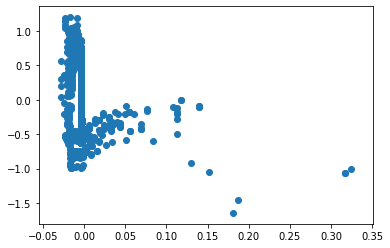

In [38]:
plt.scatter(data[0],data[1])

CPU times: user 2min 42s, sys: 14.1 s, total: 2min 57s
Wall time: 3min 23s


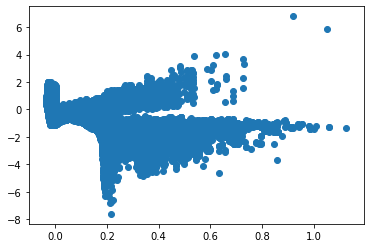

In [42]:
%%time
plt.scatter(results[0][0],results[0][1])

In [43]:
data = reduce(results)
data.shape

12653398 12653398


(2, 12653398)

CPU times: user 30.8 s, sys: 8.12 s, total: 38.9 s
Wall time: 35.6 s


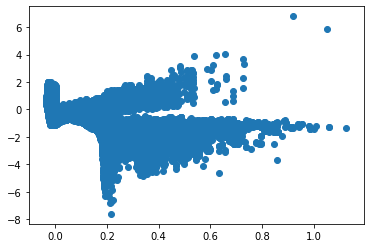

In [44]:
%%time
plt.scatter(data[0],data[1])

# Let the worker read the data

In [24]:
def CalculateMap(ObjNo, 
                 Band1='g', Band2='i', dT1=30, dT2=300, 
                 PointsPDay = 1, Thr=27.5):
    
    FilePath = '/global/homes/l/lianming/Presto-Color-2/data/2Day_Interp/SNIa-SALT2_Interp.pkl'

    with open(FilePath, 'rb') as f:
        Interp_load = pickle.load(f)
        TimeRange_load = pickle.load(f)  

    dMag = []
    Color = []

    for II in range(ObjNo):
        
        if Interp_load[Band1][II]==[] or Interp_load[Band2][II]==[]:
            continue
            
        #Decide the range and the length of XX.
        TimeRangeStart = max( TimeRange_load[Band1][II][0], TimeRange_load[Band2][II][0] - dT1/1440 )
        TimeRangeEnd = min( TimeRange_load[Band1][II][1] - dT2/1440, TimeRange_load[Band2][II][1] - dT1/1440 )

        TimeRange = TimeRangeEnd - TimeRangeStart
        SampleNo = np.int(PointsPDay*TimeRange)
        
        XX = np.random.rand(SampleNo)*TimeRange + TimeRangeStart
        
        #Calculate the values of the functions with selected x values.  
        Mag1 = Interp_load[Band1][II](XX)
        Mag2 = Interp_load[Band2][II](XX+dT1/1440)
        Mag12 = Interp_load[Band1][II](XX+dT2/1440)
        
        #Add a threshold for the results and output.
        Mask = (Mag1<Thr) * (Mag2<Thr) *(Mag12<Thr)

        dMag.extend(Mag1[Mask] - Mag12[Mask])
        Color.extend(Mag1[Mask] - Mag2[Mask])
        
    return dMag, Color

In [19]:
ObjNo = 10000

In [20]:
lazy_results = []

lazy_result = dask.delayed(CalculateMap)(ObjNo)
lazy_results.append(lazy_result)

# futures = dask.persist(*lazy_results)  # trigger computation in the background

In [21]:
%%time
results = dask.compute(*lazy_results)

CPU times: user 7.79 s, sys: 1.39 s, total: 9.18 s
Wall time: 1min 34s


In [22]:
data = reduce(results)
data.shape

3163493 3163493


(2, 3163493)

CPU times: user 29.4 s, sys: 4.24 s, total: 33.6 s
Wall time: 36.1 s


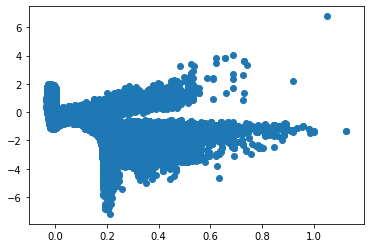

distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


In [50]:
%%time
plt.scatter(data[0],data[1])

In [10]:
ObjNo = 40000

In [11]:
lazy_results = []

lazy_result = dask.delayed(CalculateMap)(ObjNo)
lazy_results.append(lazy_result)

# futures = dask.persist(*lazy_results)  # trigger computation in the background

In [12]:
%%time
results = dask.compute(*lazy_results)

CPU times: user 20.7 s, sys: 4.34 s, total: 25 s
Wall time: 5min 26s


In [16]:
lazy_results = []

lazy_result = dask.delayed(CalculateMap)(ObjNo)
lazy_results.append(lazy_result)

# futures = dask.persist(*lazy_results)  # trigger computation in the background

In [17]:
%%time
results = dask.compute(*lazy_results)

CPU times: user 27.3 s, sys: 6.61 s, total: 33.9 s
Wall time: 5min 46s


In [13]:
ObjNo = 40000

In [14]:
lazy_results = []

lazy_result = dask.delayed(CalculateMap)(ObjNo)
lazy_results.append(lazy_result)

futures = dask.persist(*lazy_results)  # trigger computation in the background

In [15]:
%%time
results = dask.compute(*futures)

CPU times: user 19 s, sys: 4.74 s, total: 23.7 s
Wall time: 5min 40s


In [30]:
ObjNo = 10000

In [31]:
futures = client.submit(CalculateMap, ObjNo)

In [32]:
%%time
data = futures.result()

CPU times: user 6.45 s, sys: 1.19 s, total: 7.65 s
Wall time: 2min 7s


In [34]:
len(data[0])

3163474

In [35]:
import sys

In [37]:
sys.getsizeof(data[0])

27000120

---
Try with map and submit

In [39]:
futures = client.map(CalculateMap, Ind, Interp_load=Interp_load, TimeRange_load=TimeRange_load, Band1='g', Band2='i', dT1=30, dT2=300, PointsPDay=1)

In [40]:
%%time
data = client.submit(reduce, futures).result()

CPU times: user 34.6 ms, sys: 11.3 ms, total: 45.9 ms
Wall time: 57 ms


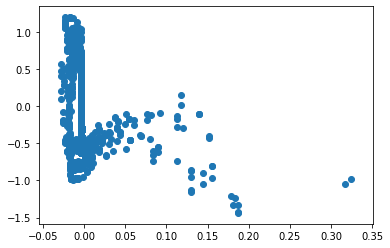

In [41]:
plt.scatter(data[0],data[1])

In [100]:
data.shape

(2, 2526)

---
# Change the way of data transmission. 

In [40]:
#Read in raw data Interp_load and TimeRange_load.
#Interp_load is a dictionary with 6 keys (bands in our case), 
#the item of each of them is a list that contains 40000 functions interpolated with scipy interp1d.
#TimeRange_load tells their domains of definition.

FilePath = '/global/homes/l/lianming/Presto-Color-2/data/2Day_Interp/SNIa-SALT2_Interp.pkl'

with open(FilePath, 'rb') as f:
    Interp_load = pickle.load(f)
    TimeRange_load = pickle.load(f)  

In [7]:
def CalculateMap(Function_Band1, Function_Band2, 
                 Time_Band1, Time_Band2, 
                 dT1=30, dT2=300, 
                 PointsPDay = 0.1, Thr=27.5):
    
           
    if Function_Band1==[] or Function_Band2==[]:
        return np.array([])

    #Decide the range and the length of XX.
    TimeRangeStart = max( Time_Band1[0], Time_Band2[0] - dT1/1440 )
    TimeRangeEnd = min( Time_Band1[1] - dT2/1440, Time_Band2[1] - dT1/1440 )

    TimeRange = TimeRangeEnd - TimeRangeStart
    SampleNo = np.int(PointsPDay*TimeRange)

    XX = np.random.rand(SampleNo)*TimeRange + TimeRangeStart

    #Calculate the values of the functions with selected x values.  
    Mag1 = Function_Band1(XX)
    Mag2 = Function_Band2(XX+dT1/1440)
    Mag12 = Function_Band1(XX+dT2/1440)

    #Add a threshold for the results and output.
    Mask = (Mag1<Thr) * (Mag2<Thr) *(Mag12<Thr)

    dMag = Mag1[Mask] - Mag12[Mask]
    Color = Mag1[Mask] - Mag2[Mask]
        
    return dMag, Color

In [8]:
def reduce(results):
    
    dMags = []
    Colors = []
    
    for dMag, Color in results:
        
#         print(len(dMag), len(Color))
        dMags.extend(dMag)
        Colors.extend(Color)
    print(len(dMags), len(Colors))
    return np.array([dMags, Colors])

In [42]:
ObjNo = 40000

In [43]:
Band1 = 'g'
Band2 = 'i'

Function_Band1_List = Interp_load[Band1][0:ObjNo]
Function_Band2_List = Interp_load[Band2][0:ObjNo]

Time_Band1_List = TimeRange_load[Band1][0:ObjNo]
Time_Band2_List = TimeRange_load[Band2][0:ObjNo]

# Function_Band1_List = Interp_load[Band1]
# Function_Band2_List = Interp_load[Band2]

# Time_Band1_List = TimeRange_load[Band1]
# Time_Band2_List = TimeRange_load[Band2]

---
Try with delayed and compute

In [44]:
%%time
lazy_results = []

for ii in range(ObjNo):
    lazy_result = dask.delayed(CalculateMap)(Function_Band1_List[ii], Function_Band2_List[ii], Time_Band1_List[ii], Time_Band2_List[ii])
    lazy_results.append(lazy_result)

futures = dask.persist(*lazy_results)  # trigger computation in the background

CPU times: user 21.7 s, sys: 3.68 s, total: 25.3 s
Wall time: 30.3 s


In [45]:
%%time
results = dask.compute(*futures)

CPU times: user 21.5 s, sys: 2.89 s, total: 24.4 s
Wall time: 34.8 s


In [46]:
%%time
lazy_results = []

for ii in range(ObjNo):
    lazy_result = dask.delayed(CalculateMap)(Function_Band1_List[ii], Function_Band2_List[ii], Time_Band1_List[ii], Time_Band2_List[ii])
    lazy_results.append(lazy_result)

# futures = dask.persist(*lazy_results)  # trigger computation in the background

CPU times: user 6.15 s, sys: 867 ms, total: 7.01 s
Wall time: 7.84 s


In [47]:
%%time
results = dask.compute(*lazy_results)

CPU times: user 1min 15s, sys: 6.16 s, total: 1min 21s
Wall time: 3min 2s


In [10]:
data = reduce(results)
data.shape

1239948 1239948


(2, 1239948)

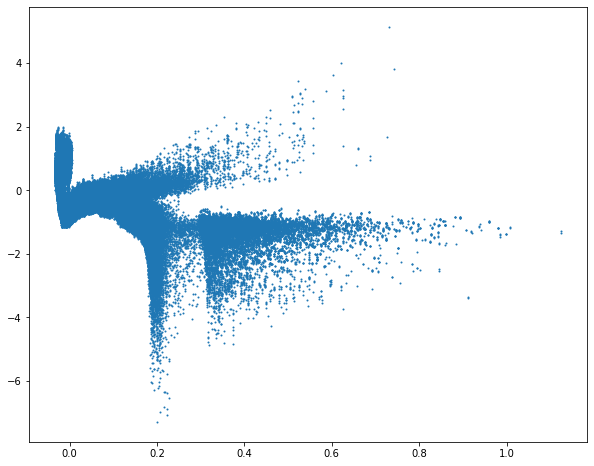

In [60]:
plt.figure(figsize=(10, 8))
plt.scatter(data[0],data[1], s=1)

In [65]:
ObjNo = 10000

In [66]:
Band1 = 'g'
Band2 = 'i'

Function_Band1_List = Interp_load[Band1][0:ObjNo]
Function_Band2_List = Interp_load[Band2][0:ObjNo]

Time_Band1_List = TimeRange_load[Band1][0:ObjNo]
Time_Band2_List = TimeRange_load[Band2][0:ObjNo]

# Function_Band1_List = Interp_load[Band1]
# Function_Band2_List = Interp_load[Band2]

# Time_Band1_List = TimeRange_load[Band1]
# Time_Band2_List = TimeRange_load[Band2]

In [13]:
%%time
lazy_results = []

for ii in range(ObjNo):
    lazy_result = dask.delayed(CalculateMap)(Function_Band1_List[ii], Function_Band2_List[ii], Time_Band1_List[ii], Time_Band2_List[ii])
    lazy_results.append(lazy_result)

futures = dask.persist(*lazy_results)  # trigger computation in the background

CPU times: user 5.56 s, sys: 987 ms, total: 6.55 s
Wall time: 6.64 s


In [14]:
%%time
results = dask.compute(*futures)

CPU times: user 8.58 s, sys: 738 ms, total: 9.32 s
Wall time: 9.86 s


In [15]:
data = reduce(results)
data.shape

309984 309984


(2, 309984)

---
Try with map and submit

In [9]:
ObjNo = 10000

In [10]:
Band1 = 'g'
Band2 = 'i'

Function_Band1_List = Interp_load[Band1][0:ObjNo]
Function_Band2_List = Interp_load[Band2][0:ObjNo]

Time_Band1_List = TimeRange_load[Band1][0:ObjNo]
Time_Band2_List = TimeRange_load[Band2][0:ObjNo]

# Function_Band1_List = Interp_load[Band1]
# Function_Band2_List = Interp_load[Band2]

# Time_Band1_List = TimeRange_load[Band1]
# Time_Band2_List = TimeRange_load[Band2]

In [20]:
%%time
futures = client.map(CalculateMap, 
                     Function_Band1_List, Function_Band2_List, 
                     Time_Band1_List, Time_Band2_List,
                     dT1=30, dT2=300, PointsPDay=1)

CPU times: user 4.71 s, sys: 518 ms, total: 5.22 s
Wall time: 5.54 s


In [21]:
%%time
data = client.gather(futures)

CPU times: user 33.6 s, sys: 3.32 s, total: 36.9 s
Wall time: 40.3 s


In [18]:
%%time
futures = client.map(CalculateMap, 
                     Function_Band1_List, Function_Band2_List, 
                     Time_Band1_List, Time_Band2_List,
                     dT1=30, dT2=300, PointsPDay=1)

CPU times: user 4.98 s, sys: 1.06 s, total: 6.04 s
Wall time: 6.32 s


In [19]:
%%time
data = client.submit(reduce, futures).result()

CPU times: user 29.2 s, sys: 2.52 s, total: 31.7 s
Wall time: 38.7 s


In [9]:
%%time

F1 = client.scatter(Function_Band1_List)
F2 = client.scatter(Function_Band2_List)

T1 = client.scatter(Time_Band1_List)
T2 = client.scatter(Time_Band2_List)


futures = client.map(CalculateMap, 
                     F1, F2, T1, T2,
                     dT1=30, dT2=300, PointsPDay=1)

CPU times: user 30.3 s, sys: 3.31 s, total: 33.6 s
Wall time: 34.1 s


In [10]:
%%time
data = client.submit(reduce, futures).result()

/usr/common/software/python/3.7-anaconda-2019.10/lib/python3.7/site-packages/distributed/worker.py:3239: UserWarning: Large object of size 1.92 MB detected in task graph: 
  (['CalculateMap-f7b32caaf58e755da1c4322109479cf9', ... bc77aa6af72'],)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s)
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:33942 remote=tcp://127.0.0.1:40267>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:33950 remote=tcp://127.0.0.1:40267>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:33952 remote=tcp://127.0.0.1:40267>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=

CPU times: user 1min 26s, sys: 7.47 s, total: 1min 34s
Wall time: 1min 43s


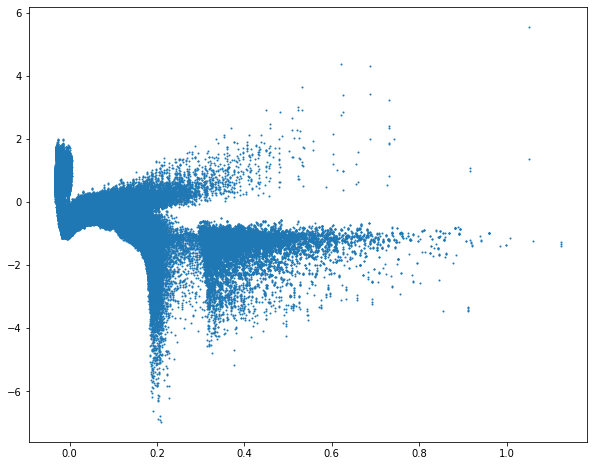

In [11]:
plt.figure(figsize=(10, 8))
plt.scatter(data[0],data[1], s=1)

In [ ]:
data.shape